# Analysis of the rent dataset

## Overview

Before we start analyzing the data and explaining our intentions, we need to get an overview of the existing data. No matter what we later want to do, we have to clean and prepocess our data in order to work with it 

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_object_dtype
pd.set_option('display.max_columns', None)
%matplotlib inline
from scipy.stats import linregress

In [2]:
df = pd.read_csv("../data/testlizenz-tuebingen-dataliteracy4students_1700939273256.csv", sep=";", encoding='unicode_escape')
df.count() 

angebot_id                    16008
anz_parken                    10830
anz_zimmer                    15865
aus_alarmanlage_janein        16008
aus_bad_dusche_janein         16008
                              ...  
oeig_dachgeschoss_janein      16008
enddate                       15707
aus_balkon_terrasse_janein    16008
aus_wintergarten_janein       16008
aus_garten_eigen_janein       16008
Length: 87, dtype: int64

In [3]:
# include year column
df['year'] = df['startdate'].str[:4] 
df['endyear'] = df['enddate'].str[:4] 

In [4]:
df["month"] = pd.DatetimeIndex(df['startdate']).month

In [5]:
df

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
0      3594713336         NaN         2,                       0   
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
...           ...         ...        ...                     ...   
16003  3041045247         NaN        2,5                       0   
16004  3040210896         NaN         4,                       0   
16005  3058502400         NaN         7,                       0   
16006  3032926122         NaN         4,                       0   
16007  3043830326         NaN         7,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
0                          1                        0   
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
...                      ...                      ...   
16003                      1                        0   
16004                      0                        1   
16005                      1                        0   
16006                      0                        0   
16007                      0                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
0                               0                     0   
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
...                           ...                   ...   
16003                           1                     1   
16004                           0                     1   
16005                           0                     0   
16006                           0                     1   
16007                           0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
16003                         0                          0   
16004                         0                          0   
16005                         0                          0   
16006                         0                          0   
16007                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
16003                           0                          0   
16004                           0                          0   
16005                           0                          1   
16006                           0                          0   
16007                           0                          1   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
0                            0                 NaN   
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4           

### How many houses and flats are in the dataset?

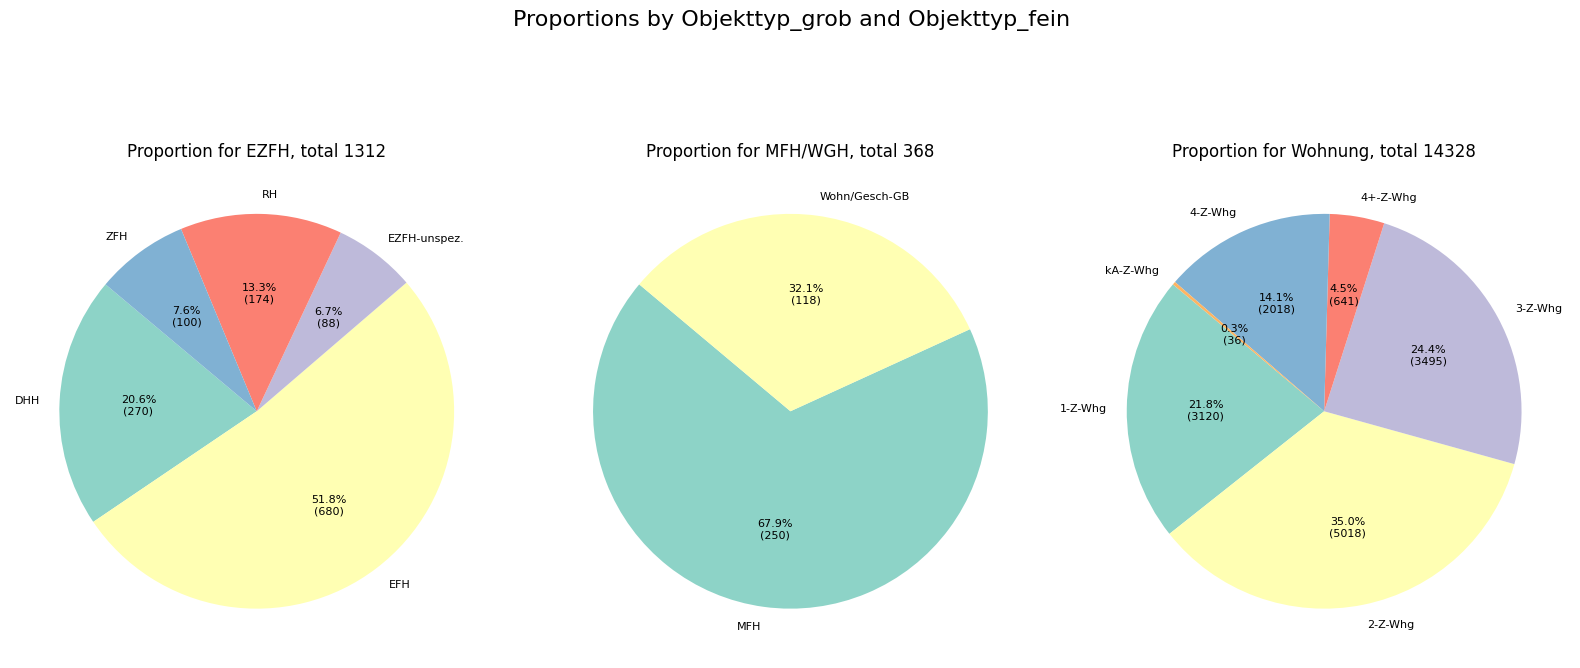

In [6]:
grouped_df = df.groupby(["objekttyp_grob", "objekttyp_fein"]).size().reset_index(name='count')
unique_grobs = grouped_df['objekttyp_grob'].unique()
fig, axes = plt.subplots(1, len(unique_grobs), figsize=(16, 8), subplot_kw=dict(aspect="equal"))
subtitle_text = ""
colors = plt.cm.Set3.colors  # Set color palette, adjust as needed

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


for i, (grob, ax) in enumerate(zip(unique_grobs, axes.flatten())):
    grob_df = grouped_df[grouped_df['objekttyp_grob'] == grob]
    wedges, texts, autotexts = ax.pie(grob_df['count'], labels=grob_df['objekttyp_fein'], autopct=lambda pct: func(pct, grob_df['count']),
                                      colors=colors, startangle=140)
    ax.set_title(f'Proportion for {grob}, total {grob_df["count"].sum()}')
    
    # Increase the size of the labels and percentage values for better visibility
    for text in texts + autotexts:
        text.set_fontsize(8)
    # subtitle_text += f"Total for {grob}: {grob_df['count'].sum()} \n \n"
    
fig.suptitle(f'{subtitle_text}\n', fontsize=16, style='italic')
fig.suptitle('Proportions by Objekttyp_grob and Objekttyp_fein', fontsize=16)
fig.tight_layout()
plt.show()

#### We can clearly see that there are far more flats than houses.

### How many of those flats and houses are for sail, how many for rent?

In [7]:
df.groupby(["objekttyp_grob", "nachfrageart"]).size().reset_index(name='count')

objekttyp_grob nachfrageart  count
0           EZFH         kauf   1032
1           EZFH        miete    280
2        MFH/WGH         kauf    368
3        Wohnung         kauf   3754
4        Wohnung        miete  10574

-------------

# Where are those flats and houses located?
Now that we have generated a quick overview about our data, we will now focus on where these flats and houses actually are. We want to identify the region in Tübingen that has the most offers. Once we have categorized the data by region, we will also look at the price distribution in each region to compare the prices but simultaneously the regions.  

## Cleaning process..

*With which loaction do we start?*
Given are two different location attributes, *oadr_u2* being more specific than *oadr_u1*.

In [8]:
df_total_oadr_u1 = df.groupby(["oadr_u1"]).size().reset_index(name='count')
df_total_oadr_u1_count = df["oadr_u1"].isnull().sum()
print(f"Total number of OADR_U1: {df_total_oadr_u1['count'].sum()}")
print(f"Total number of OADR_U1 with no value: {df_total_oadr_u1_count}")
df.groupby(["oadr_u1"]).size().reset_index(name='count')

Total number of OADR_U1: 11927
Total number of OADR_U1 with no value: 4081


oadr_u1  count
0     Bebenhausen     63
1            Bühl    403
2     Derendingen    870
3       Hagelloch    182
4        Hirschau    472
5       Kilchberg    138
6         Lustnau   1456
7       Pfrondorf    420
8        Tübingen   7456
9   Unterjesingen    329
10       Weilheim    138

In [9]:
df_total_oadr_u2 = df.groupby(["oadr_u2"]).size().reset_index(name='count')
df_total_oadr_u2_count = df["oadr_u2"].isnull().sum()
print(f"Total number of OADR_U2: {df_total_oadr_u2['count'].sum()}")
print(f"Total number of OADR_U2 with no value: {df_total_oadr_u2_count}")
df.groupby(["oadr_u2"]).size().reset_index(name='count')

Total number of OADR_U2: 9131
Total number of OADR_U2 with no value: 6877


oadr_u2  count
0                                  Aeule     76
1   Au/Unterer Wert/Französiches Viertel    481
2                            Bebenhausen     63
3                                   Bühl    403
4                             De-Zentrum     90
5                        Denzenberg/Sand    191
6               Feuerhägle/Mühlenviertel    269
7                            Gartenstadt     26
8                              Hagelloch    182
9                               Hirschau    472
10                             Kilchberg    138
11  Lustnau-Zentrum/Herrlesberg/Stäudach    403
12                              Neuhalde    111
13                             Pfrondorf    420
14             Schönblick/Waldhäuser Ost    614
15                              Südstadt   1047
16                           Universität   1030
17                         Unterjesingen    329
18                                 Wanne    661
19                              Weilheim    138
20                             Weststadt   1053
21                               Zentrum    727
22                Österberg/Gartenstraße    207

In [10]:
df[df["oadr_u2"].isna()].groupby(["oadr_u1"]).size().reset_index(name='count')

oadr_u1  count
0  Derendingen    485
1      Lustnau    675
2     Tübingen   1636

In [11]:
df[df["oadr_u1"].isna()].groupby(["oadr_u2"]).size().reset_index(name='count')

Empty DataFrame
Columns: [oadr_u2, count]
Index: []

In [12]:
df.groupby(["oadr_u2", "oadr_u1"]).size().reset_index(name='count').sort_values(by=['oadr_u1'], ascending=False)

oadr_u2        oadr_u1  count
19                              Weilheim       Weilheim    138
17                         Unterjesingen  Unterjesingen    329
22                Österberg/Gartenstraße       Tübingen    207
21                               Zentrum       Tübingen    727
20                             Weststadt       Tübingen   1053
18                                 Wanne       Tübingen    661
16                           Universität       Tübingen   1030
15                              Südstadt       Tübingen   1047
14             Schönblick/Waldhäuser Ost       Tübingen    614
1   Au/Unterer Wert/Französiches Viertel       Tübingen    481
13                             Pfrondorf      Pfrondorf    420
12                              Neuhalde        Lustnau    111
0                                  Aeule        Lustnau     76
5                        Denzenberg/Sand        Lustnau    191
11  Lustnau-Zentrum/Herrlesberg/Stäudach        Lustnau    403
10                             Kilchberg      Kilchberg    138
9                               Hirschau       Hirschau    472
8                              Hagelloch      Hagelloch    182
7                            Gartenstadt    Derendingen     26
6               Feuerhägle/Mühlenviertel    Derendingen    269
4                             De-Zentrum    Derendingen     90
3                                   Bühl           Bühl    403
2                            Bebenhausen    Bebenhausen     63

In [13]:
oadr_u2 = df["oadr_u2"].unique().tolist()
cleaned_oadr_2 = [x for x in oadr_u2 if x == x]
cleaned_oadr_2

['Universität',
 'Schönblick/Waldhäuser Ost',
 'Zentrum',
 'Bühl',
 'Südstadt',
 'Hagelloch',
 'Kilchberg',
 'Au/Unterer Wert/Französiches Viertel',
 'Weststadt',
 'Bebenhausen',
 'Hirschau',
 'Österberg/Gartenstraße',
 'Pfrondorf',
 'Wanne',
 'Unterjesingen',
 'Feuerhägle/Mühlenviertel',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'De-Zentrum',
 'Aeule',
 'Weilheim',
 'Denzenberg/Sand',
 'Gartenstadt',
 'Neuhalde']

For the further approach, knowing where the houses are is important. Therefore we will now clean the data and remove all entries that do not have a location attribute.

In [14]:
df_w_loc = df[df['oadr_u1'].notna()]
df_wo_loc = df[df['oadr_u1'].isna()]
print(f"Total number of rows with location: {df_w_loc.shape[0]}")
print(f"Total number of rows without location: {df_wo_loc.shape[0]}")

Total number of rows with location: 11927
Total number of rows without location: 4081


### Adjusting entries
From previous analysis I know that the integer and float values in the dataset are kind of messy, pandas cant interpret them as actual values because they are seperated with **`,`** instead of **`.`** Lets fix this.

In [15]:
df_w_loc

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
5      3593974527         2.0        2,5                       0   
...           ...         ...        ...                     ...   
15998    27439257         1.0         5,                       0   
15999    27424499         1.0         2,                       0   
16001    27375419         1.0         6,                       0   
16002    27260230         1.0         6,                       0   
16004  3040210896         NaN         4,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   
5           

In [16]:
df_w_loc["fl_wohnen"].dtype

dtype('O')

In [17]:
for column in df.columns:
    if is_object_dtype(df[column]):
        if df[column].str.contains(',').any(): 
            df[column] = df[column].str.replace(',', '.').astype(float)
            df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
df_w_loc

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_2044/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_2044/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_2044/1307623920.py:5: SettingWithCopyWarning: 
A value 

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2.0                       0   
2      3593975043         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   
4      3594061704         1.0         3.0                       0   
5      3593974527         2.0         2.5                       0   
...           ...         ...         ...                     ...   
15998    27439257         1.0         5.0                       0   
15999    27424499         1.0         2.0                       0   
16001    27375419         1.0         6.0                       0   
16002    27260230         1.0         6.0                       0   
16004  3040210896         NaN         4.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   


In [18]:
df_w_loc.shape[0]

11927

## Now that we have cleaned our data, lets look at the regions

In [19]:
df_w_loc.groupby(["oadr_u1"]).size().reset_index(name='count')

oadr_u1  count
0     Bebenhausen     63
1            Bühl    403
2     Derendingen    870
3       Hagelloch    182
4        Hirschau    472
5       Kilchberg    138
6         Lustnau   1456
7       Pfrondorf    420
8        Tübingen   7456
9   Unterjesingen    329
10       Weilheim    138

In [20]:
df_agg = df_w_loc.groupby(["oadr_u2", "year", "month"]).agg({'kstn_miete_kalt_pqm': ['mean', 'min', 'max', 'std']}).reset_index()

In [21]:
df_agg['year_month'] = df_agg['year'].astype(str) + '-' + df_agg['month'].astype(str).str.zfill(2)


In [22]:
df_agg = df_agg.sort_values(by=['year_month'])

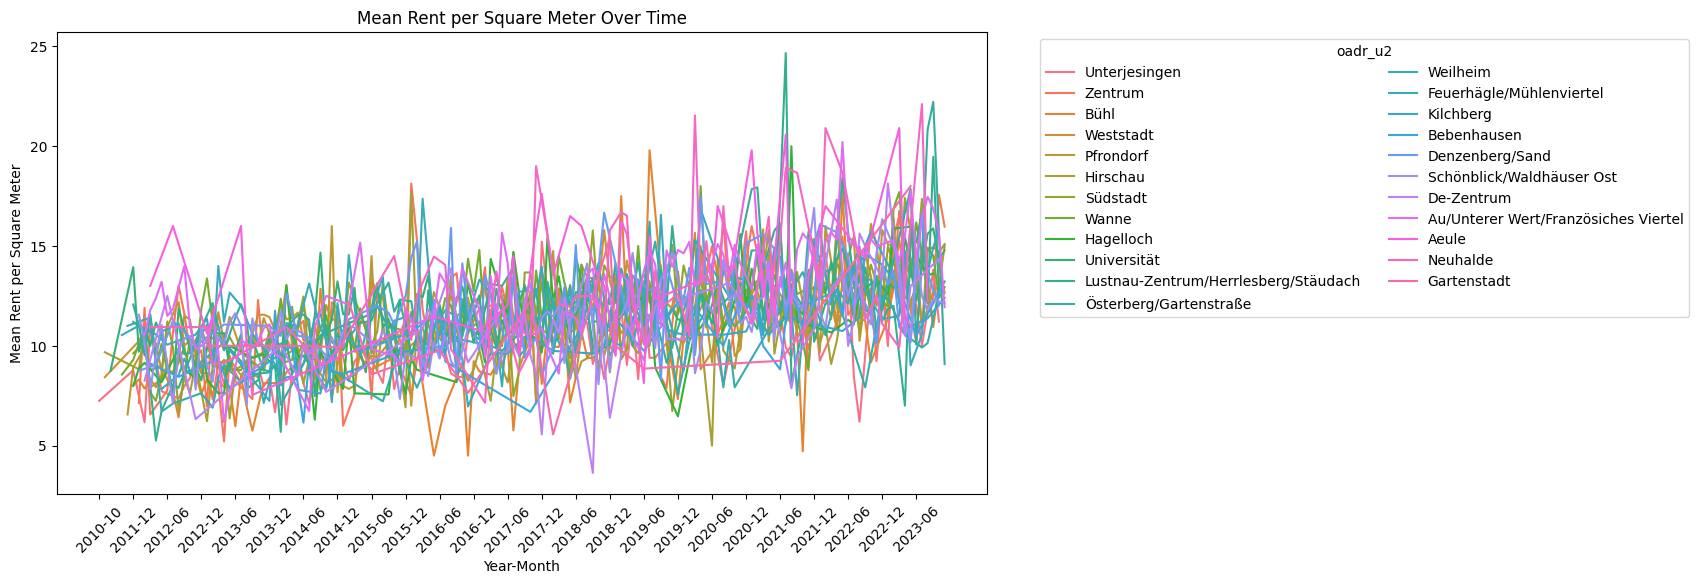

In [23]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_agg, x="year_month", y=("kstn_miete_kalt_pqm", "mean"), hue="oadr_u2")
plt.title('Mean Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Rent per Square Meter')
plt.legend(title='oadr_u2', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust ncol as needed

# Show the plot
plt.xticks(df_agg['year_month'].unique()[::6], rotation=45)
plt.show()

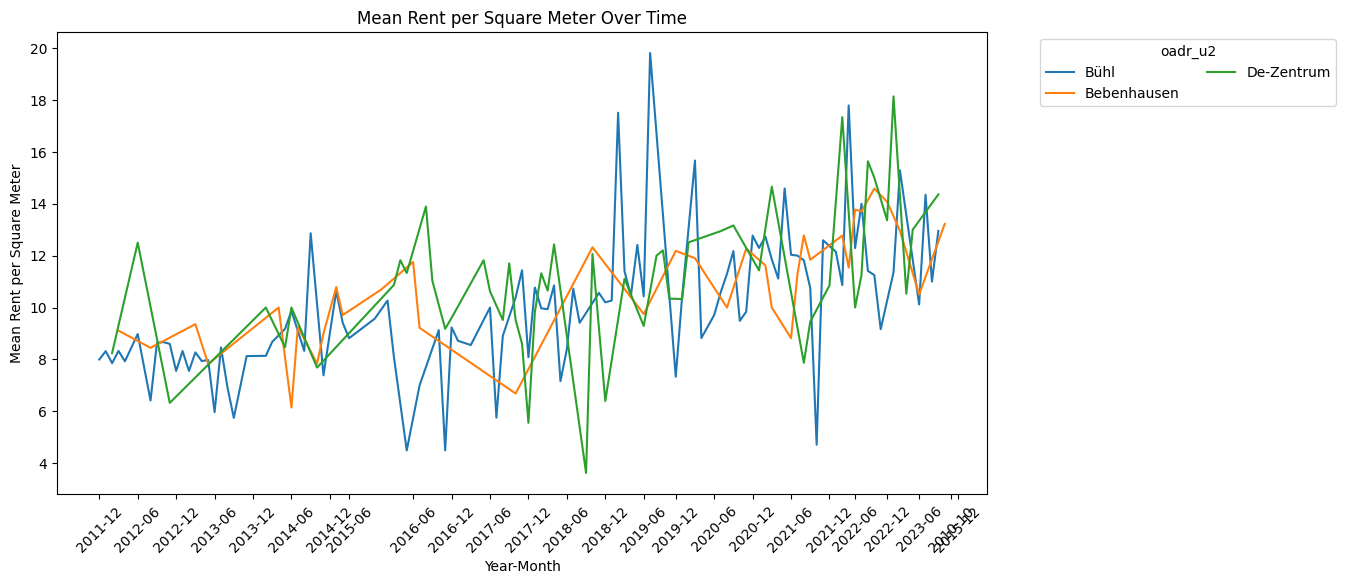

In [24]:
plt.figure(figsize=(12, 6))
data_less = df_agg[df_agg["oadr_u2"].isin(["Bühl", "Bebenhausen", "De-Zentrum"])]

sns.lineplot(data=data_less, x="year_month", y=("kstn_miete_kalt_pqm", "mean"), hue="oadr_u2")
plt.title('Mean Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Rent per Square Meter')
plt.legend(title='oadr_u2', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust ncol as needed

# Show the plot
plt.xticks(df_agg['year_month'].unique()[::6], rotation=45)
plt.show()

## Moving average

In [25]:
df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)
df_w_loc = df_w_loc.sort_values(by=['year_month'])
print(f"Size: {df_w_loc.shape[0]}")
df_w_loc["kstn_miete_kalt_pqm"].isna().sum()
df_w_loc_only_numb = df_w_loc[df_w_loc["kstn_miete_kalt_pqm"].notna()]




Size: 11927


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_2044/1250935322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)


In [26]:
number_series = df_w_loc_only_numb["kstn_miete_kalt_pqm"]
windows = number_series.rolling(window=30)
moving_averages = windows.mean()
moving_averages_list = list(moving_averages)
final_list = moving_averages_list[29:]
print(final_list)

[9.453, 9.510666666666667, 9.346333333333332, 9.366333333333333, 9.383999999999999, 9.396666666666667, 9.476999999999999, 9.519666666666666, 9.501666666666667, 9.495333333333333, 9.430666666666667, 9.618, 9.518, 9.57, 9.514999999999999, 9.369, 9.294, 9.222, 9.252999999999998, 9.208333333333334, 9.299, 9.395666666666667, 9.424333333333331, 9.530666666666665, 9.498666666666667, 9.452, 9.579666666666666, 9.572666666666665, 9.596, 9.603666666666667, 9.534666666666668, 9.621, 9.82, 9.653333333333332, 9.700333333333333, 9.743333333333334, 9.700333333333335, 9.669, 9.607333333333333, 9.611666666666666, 9.672333333333333, 9.546333333333333, 9.654, 9.613, 9.697000000000001, 9.676666666666668, 9.877333333333333, 9.886000000000001, 9.879, 9.895, 9.897666666666668, 9.699666666666666, 9.736666666666668, 9.741333333333333, 9.656666666666666, 9.629333333333333, 9.551, 9.581, 9.408, 9.481, 9.559, 9.473666666666666, 9.416333333333332, 9.504, 9.540333333333333, 9.558, 9.633999999999999, 9.56566666666666

In [27]:
df_copy = df_w_loc_only_numb
# df_copy["moving_average"] = np.nan

In [28]:
df_copy

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15993    44458486         2.0         5.5                       0   
15997    40569012         NaN         5.0                       0   
15999    27424499         1.0         2.0                       0   
15966   149252554         3.0         6.0                       0   
...           ...         ...         ...                     ...   
47     3591985311         1.0         4.0                       0   
46     3592041970         1.0         2.0                       0   
42     3592182444         1.0         3.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15993                      0                        1   
15997                      0                        1   
15999                      1                        0   
15966                      1                        1   
...                      ...                      ...   
47                         1                        1   
46                         0                        1   
42                         0                        0   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15993                           0                     1   
15997                           1                     0   
15999                           0                     1   
15966                           1                     1   
...                           ...                   ...   
47                              1                     1   
46                              0                     1   
42                              0                     0   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15993                         0                          0   
15997                         0                          0   
15999                         0                          0   
15966                         0                          0   
...                         ...                        ...   
47                            0                          0   
46                            0                          0   
42                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15993                           0                          0   
15997                           0                          0   
15999                           0                          0   
15966                           0                          0   
...                           ...                        ...   
47                              1                          0   
46                              0                          0   
42                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15993                        0                  Öl   
15997                        0                 Gas   
15999                        0             Elektro   


[]

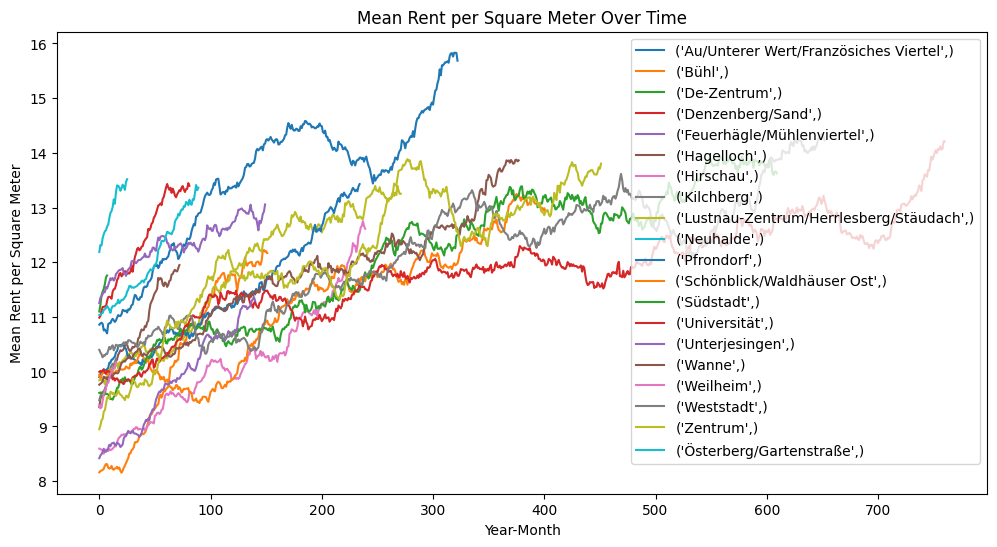

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
for group,val in df_w_loc_only_numb.groupby(["oadr_u2"]):
    # do moving average
    number_series = val["kstn_miete_kalt_pqm"]
    windows = number_series.rolling(window=60)
    moving_averages = windows.mean()
    # df_copy.loc[df_copy["oadr_u2"] == group, "moving_average"] = moving_averages
    moving_averages_list = list(moving_averages)
    final_list = moving_averages_list[59:]
    # add lineplot to fig
    sns.lineplot(data=final_list, ax=ax, label=group)
plt.title('Mean Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Rent per Square Meter')
plt.plot()
    

In [30]:
for group,val in df_w_loc_only_numb.groupby(["oadr_u2"]):
    # do moving average
    number_series = val["kstn_miete_kalt_pqm"]
    windows = number_series.rolling(window=30)
    moving_averages = windows.mean()
    # df_copy.loc[df_copy["oadr_u2"] == group, "moving_average"] = moving_averages
    moving_averages_list = list(moving_averages)
    final_list = moving_averages_list[29:]
    for i,angebots_id in enumerate(val["angebot_id"].unique()):
        df_copy.loc[df_copy["angebot_id"] == angebots_id, "moving_average"] = moving_averages_list[i]

        
    

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_2044/1998007818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.loc[df_copy["angebot_id"] == angebots_id, "moving_average"] = moving_averages_list[i]


In [31]:
df_copy["moving_average"].notna().sum()

5714

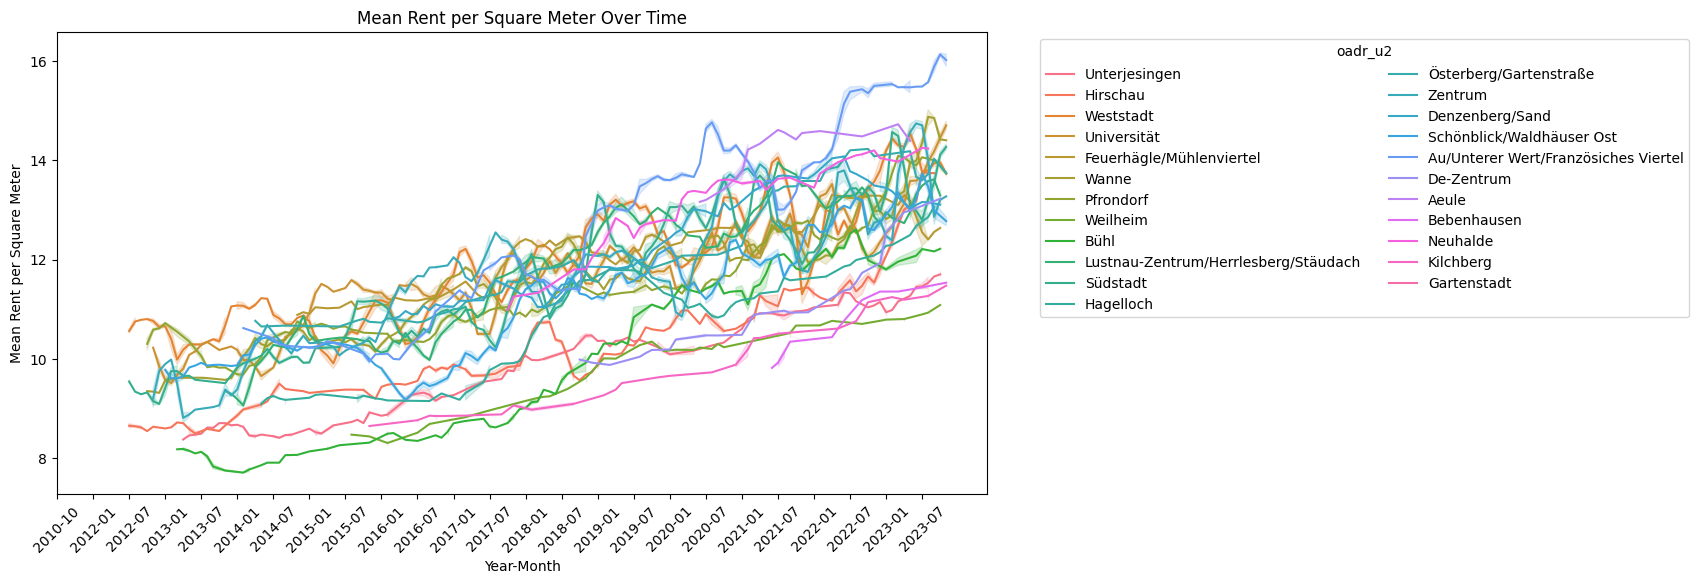

In [32]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_copy, x="year_month", y="moving_average", hue="oadr_u2")
plt.title('Mean Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Rent per Square Meter')
plt.legend(title='oadr_u2', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust ncol as needed

# Show the plot
plt.xticks(df_copy['year_month'].unique()[::6], rotation=45)
plt.show()

### Difficult task
- We have a lot of oadr_u2, so looking at each one individually is going to be quite messy
- I also dont know how to handle the fact that we have months and years, how to plot that on the x-axis

### possible solutions
- use oadr_u1
- look at specific oadr_u2 
- ?

# Take population into account

## Nutze den Link von oben für Bevölkerung

In [33]:
data = {
    "region": [
        "Zentrum", "Universität", "Wanne", "Schönblick/Waldhäuser Ost",
        "Österberg/Gartenstraße", "Au/Unterer Wert/Französiches Viertel",
        "Südstadt", "Weststadt", "Lustnau-Zentrum/Herrlesberg/Stäudach",
        "Denzenberg/Sand", "Neuhalde", "Aeule", "De-Zentrum",
        "Feuerhägle/Mühlenviertel", "Gartenstadt", "Bebenhausen",
        "Pfrondorf", "Weilheim", "Kilchberg", "Bühl", "Hirschau",
        "Unterjesingen", "Hagelloch", "Gesamt"
    ],
    "2016": [
        6430, 8242, 5384, 9779, 2509, 3656, 10459, 8519, 5908,
        2421, 1261, 985, 1863, 4484, 494, 343, 3343, 1498, 1252,
        2114, 3289, 2580, 1713, 88526
    ],
    "2017": [
        6503, 8299, 5370, 9878, 2580, 3832, 10484, 8622, 5950,
        2438, 1287, 988, 1860, 4857, 496, 328, 3360, 1468, 1271,
        2125, 3288, 2624, 1702, 89610
    ],
    "2018": [
        6479, 8524, 5359, 9838, 2580, 4248, 10518, 8687, 5957,
        2479, 1318, 995, 1888, 5191, 473, 338, 3363, 1445, 1299,
        2145, 3304, 2627, 1709, 90764
    ],
    "2019": [
        6516, 8618, 5528, 9968, 2632, 4678, 10618, 8778, 6037,
        2499, 1315, 984, 1846, 5110, 473, 326, 3348, 1467, 1295,
        2172, 3276, 2640, 1715, 91839
    ],
    "2020": [
        6371, 8445, 5469, 9772, 2685, 4997, 10519, 8607, 5910,
        2550, 1320, 977, 1810, 4806, 463, 333, 3319, 1446, 1287,
        2154, 3297, 2627, 1713, 90877
    ],
    "2021": [
        6501, 8593, 5541, 9959, 2708, 5291, 10578, 8708, 5930,
        2605, 1300, 958, 1789, 5061, 457, 336, 3315, 1443, 1274,
        2171, 3359, 2566, 1727, 92170
    ],
    "2022": [
        6540, 8568, 5665, 10004, 2707, 5272, 10616, 8828, 5952,
        2586, 1287, 1033, 1780, 5206, 459, 322, 3348, 1475, 1266,
        2182, 3384, 2567, 1753, 92800
    ]
}

# Erstellen des DataFrames
df_people = pd.DataFrame(data)
df_people = df_people.set_index("region")

print(df)


       angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
0      3594713336         NaN         2.0                       0   
1      3594016393         NaN         2.0                       0   
2      3593975043         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   
4      3594061704         1.0         3.0                       0   
...           ...         ...         ...                     ...   
16003  3041045247         NaN         2.5                       0   
16004  3040210896         NaN         4.0                       0   
16005  3058502400         NaN         7.0                       0   
16006  3032926122         NaN         4.0                       0   
16007  3043830326         NaN         7.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
0                          1                        0   
1                          1                        0   


### Calculate average per population per region, aint no much difference between the years, I guess its legit to do that

In [34]:
# calculate mean from 2016 to 2022
mean_pop = df_people.mean(axis=1).round(0).astype(int)
mean_pop

region
Zentrum                                  6477
Universität                              8470
Wanne                                    5474
Schönblick/Waldhäuser Ost                9885
Österberg/Gartenstraße                   2629
Au/Unterer Wert/Französiches Viertel     4568
Südstadt                                10542
Weststadt                                8678
Lustnau-Zentrum/Herrlesberg/Stäudach     5949
Denzenberg/Sand                          2511
Neuhalde                                 1298
Aeule                                     989
De-Zentrum                               1834
Feuerhägle/Mühlenviertel                 4959
Gartenstadt                               474
Bebenhausen                               332
Pfrondorf                                3342
Weilheim                                 1463
Kilchberg                                1278
Bühl                                     2152
Hirschau                                 3314
Unterjesingen              

# Scatter plot und lineare Regression

Falls der approach nicht gut aussieht, müssen wir vielleicht auf polynomial regression umsteigen

In [35]:
interesting_regions = df_w_loc["oadr_u2"].unique().tolist()
interesting_regions = [x for x in interesting_regions if x == x]
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15991    58854993         1.0         3.0                       0   
15992    53677475         1.0         3.0                       0   
15993    44458486         2.0         5.5                       0   
15995    43152961         2.0         4.0                       0   
...           ...         ...         ...                     ...   
34     3592611553         1.0         4.0                       0   
33     3592611568         1.0         3.0                       0   
32     3592611656         1.0         3.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15991                      1                        0   
15992                      0                        0   
15993                      0                        1   
15995                      0                        0   
...                      ...                      ...   
34                         0                        0   
33                         0                        0   
32                         0                        0   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15991                           1                     1   
15992                           1                     1   
15993                           0                     1   
15995                           0                     1   
...                           ...                   ...   
34                              0                     0   
33                              0                     0   
32                              0                     0   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15991                         0                          0   
15992                         0                          0   
15993                         0                          0   
15995                         0                          0   
...                         ...                        ...   
34                            0                          0   
33                            0                          0   
32                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15991                           0                          0   
15992                           0                          0   
15993                           0                          0   
15995                           0                          0   
...                           ...                        ...   
34                              0                          0   
33                              0                          0   
32                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15991                        0                 Gas   
15992                        0                 NaN   
15993                        0                  Öl   


In [36]:
df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)
df_w_loc = df_w_loc.sort_values(by=['year_month'])
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15996    40706032         2.0         3.0                       0   
16001    27375419         1.0         6.0                       0   
15998    27439257         1.0         5.0                       0   
15997    40569012         NaN         5.0                       0   
...           ...         ...         ...                     ...   
3      3594255459         1.0         3.0                       0   
2      3593975043         NaN         1.0                       0   
26     3592807854         1.0         NaN                       0   
8      3593834802         8.0        18.5                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15996                      1                        0   
16001                      1                        1   
15998                      1                        1   
15997                      0                        1   
...                      ...                      ...   
3                          1                        1   
2                          0                        0   
26                         0                        1   
8                          0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15996                           1                     1   
16001                           0                     0   
15998                           0                     1   
15997                           1                     0   
...                           ...                   ...   
3                               0                     1   
2                               0                     0   
26                              0                     0   
8                               0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15996                         0                          0   
16001                         0                          0   
15998                         0                          0   
15997                         0                          0   
...                         ...                        ...   
3                             0                          0   
2                             0                          0   
26                            0                          0   
8                             0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15996                           0                          0   
16001                           0                          1   
15998                           0                          0   
15997                           0                          0   
...                           ...                        ...   
3                               0                          0   
2                               0                          0   
26                              0                          0   
8                               1                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15996                        0                 Gas   
16001                        0          Alternativ   
15998                        0                 Gas   


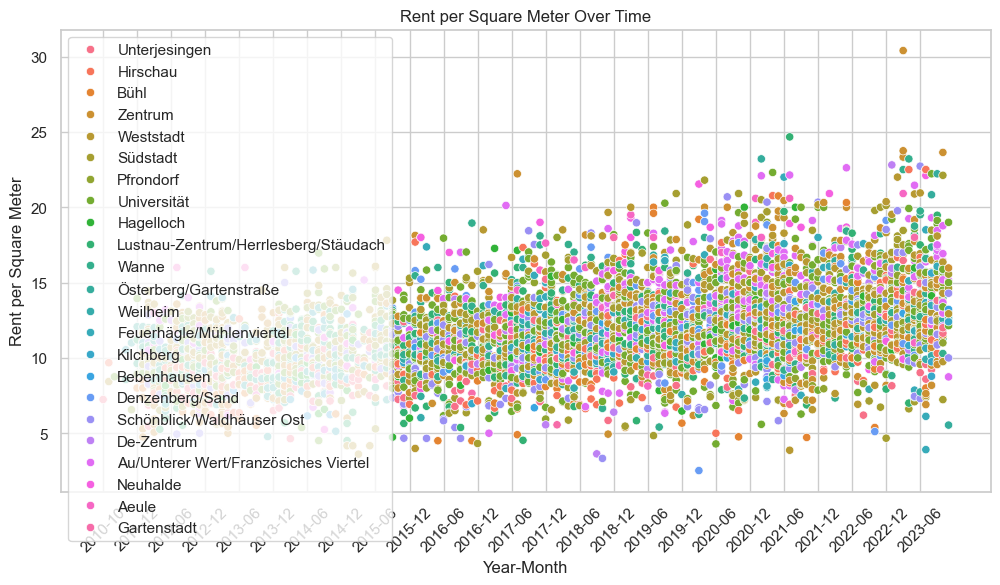

In [37]:
df_w_loc_interesting = df_w_loc[df_w_loc["oadr_u2"].isin(interesting_regions)]
# scatter plot with seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=df_w_loc_interesting, x="year_month", y="kstn_miete_kalt_pqm", hue="oadr_u2")
plt.title('Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.xticks(df_w_loc_interesting['year_month'].unique()[::6], rotation=45)
plt.ylabel('Rent per Square Meter')
plt.legend()
plt.show()

## Linear regression
Weil wir als X-Werte das Datum haben, können wir nicht einfach linear regression anwenden. Wir gehen wie folgt vor:
1) Wir ändern unsere Werte zu ordinalen Werten
2) Splitten x und y
3) Fitten die Kurve
4) Ploten die Kurve in die scatter plots rein

### 1) Ordinal values

In [39]:
df_w_loc_interesting_copy = df_w_loc_interesting.copy()
df_w_loc_interesting_copy["startdate"]

16004    2010-10-15
15996    2011-07-25
16001    2011-07-22
15998    2011-07-23
15999    2011-07-23
            ...    
3        2023-11-14
2        2023-11-15
26       2023-11-08
8        2023-11-14
1        2023-11-15
Name: startdate, Length: 9131, dtype: object

In [40]:
import datetime as dt
df_w_loc_interesting_copy['startdate'] = pd.to_datetime(df_w_loc_interesting_copy['startdate'])
df_w_loc_interesting_copy['startdate_ordinal']=df_w_loc_interesting_copy['startdate'].map(dt.datetime.toordinal)
df_w_loc_interesting_copy['startdate_ordinal']

16004    734060
15996    734343
16001    734340
15998    734341
15999    734341
          ...  
3        738838
2        738839
26       738832
8        738838
1        738839
Name: startdate_ordinal, Length: 9131, dtype: int64

### 2) Split x and y

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].isna().sum()

2763

In [43]:
df_w_loc_interesting_copy = df_w_loc_interesting_copy[df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].notna()]

In [44]:
df_w_loc_interesting_copy

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15999    27424499         1.0         2.0                       0   
15993    44458486         2.0         5.5                       0   
15989    60855988         NaN         2.0                       0   
15945   747572580         1.0         2.0                       0   
...           ...         ...         ...                     ...   
25     3593245979         1.0         3.5                       0   
10     3594183364         1.0         3.0                       0   
3      3594255459         1.0         3.0                       0   
2      3593975043         NaN         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15999                      1                        0   
15993                      0                        1   
15989                      1                        0   
15945                      0                        0   
...                      ...                      ...   
25                         1                        0   
10                         1                        1   
3                          1                        1   
2                          0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15999                           0                     1   
15993                           0                     1   
15989                           0                     0   
15945                           0                     0   
...                           ...                   ...   
25                              1                     1   
10                              1                     1   
3                               0                     1   
2                               0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15999                         0                          0   
15993                         0                          0   
15989                         0                          0   
15945                         0                          0   
...                         ...                        ...   
25                            0                          0   
10                            0                          0   
3                             0                          0   
2                             0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15999                           0                          0   
15993                           0                          0   
15989                           0                          0   
15945                           0                          0   
...                           ...                        ...   
25                              0                          0   
10                              0                          0   
3                               0                          0   
2                               0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15999                        0             Elektro   
15993                        0                  Öl   
15989                        0             Elektro   


In [45]:
# df_w_loc_interesting_copy_uni=df_w_loc_interesting_copy[df_w_loc_interesting_copy["oadr_u2"] == "Universität"]
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()

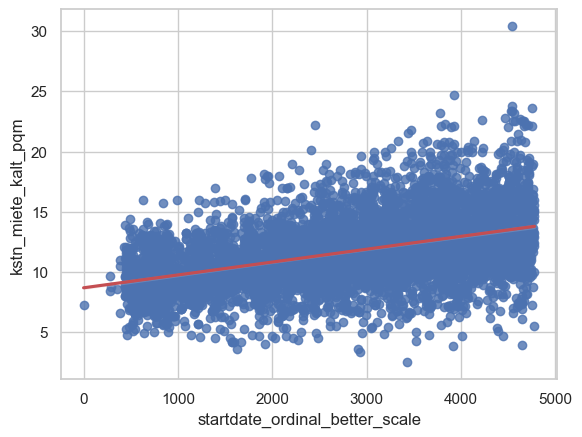

In [46]:
ax = sns.regplot(
    data=df_w_loc_interesting_copy,
    x='startdate_ordinal_better_scale',
    y='kstn_miete_kalt_pqm',
    line_kws=dict(color="r")
    
)

In [47]:
interesting_regions

['Unterjesingen',
 'Hirschau',
 'Südstadt',
 'Pfrondorf',
 'Zentrum',
 'Weststadt',
 'Bühl',
 'Wanne',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'Hagelloch',
 'Universität',
 'Österberg/Gartenstraße',
 'Feuerhägle/Mühlenviertel',
 'Weilheim',
 'Kilchberg',
 'Bebenhausen',
 'Schönblick/Waldhäuser Ost',
 'Denzenberg/Sand',
 'Au/Unterer Wert/Französiches Viertel',
 'De-Zentrum',
 'Aeule',
 'Neuhalde',
 'Gartenstadt']

In [105]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal"]
    
    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    x = x.values.reshape(-1, 1)
    print(i)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)
lg_df

Unterjesingen
Hirschau
Südstadt
Pfrondorf
Zentrum
Weststadt
Bühl
Wanne
Lustnau-Zentrum/Herrlesberg/Stäudach
Hagelloch
Universität
Österberg/Gartenstraße
Feuerhägle/Mühlenviertel
Weilheim
Kilchberg
Bebenhausen
Schönblick/Waldhäuser Ost
Denzenberg/Sand
Au/Unterer Wert/Französiches Viertel
De-Zentrum
Aeule
Neuhalde
Gartenstadt


oadr_u2      r_sq    intercept     slope
0                          Unterjesingen  0.288094  -657.091994  0.000906
1                               Hirschau  0.290033  -750.870944  0.001033
2                               Südstadt  0.208984  -828.069318  0.001140
3                              Pfrondorf  0.271629  -649.497910  0.000897
4                                Zentrum  0.171994  -770.666111  0.001062
5                              Weststadt  0.167302  -630.735454  0.000872
6                                   Bühl  0.305393  -896.249290  0.001230
7                                  Wanne  0.237278  -722.686757  0.000997
8   Lustnau-Zentrum/Herrlesberg/Stäudach  0.211597  -849.641576  0.001169
9                              Hagelloch  0.326786  -849.425658  0.001168
10                           Universität  0.136493  -614.075777  0.000849
11                Österberg/Gartenstraße  0.202407  -673.030207  0.000930
12              Feuerhägle/Mühlenviertel  0.056991  -377.184533  0.000528
13                              Weilheim  0.290962  -635.729213  0.000876
14                             Kilchberg  0.477327  -749.823855  0.001032
15                           Bebenhausen  0.419989  -751.355934  0.001034
16             Schönblick/Waldhäuser Ost  0.183645  -672.131696  0.000927
17                       Denzenberg/Sand  0.148565  -706.202914  0.000975
18  Au/Unterer Wert/Französiches Viertel  0.263606 -1071.008444  0.001471
19                            De-Zentrum  0.268348 -1023.003149  0.001403
20                                 Aeule  0.079618  -628.838743  0.000872
21                              Neuhalde  0.139433  -941.645080  0.001295
22                           Gartenstadt  0.184904 -1103.524420  0.001513

In [48]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope", "p_val"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal_better_scale"]
    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    test_result = linregress(x=x, y=y)
    print(test_result)
    x = x.values.reshape(-1, 1)
    print(i)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
 
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope, "p_val":test_result.pvalue} ,ignore_index=True)
lg_df.sort_values(by=["slope"])

LinregressResult(slope=0.000905517215253691, intercept=7.611972782205867, rvalue=0.536744136386047, pvalue=2.5580390152366287e-16, stderr=0.00010115982103575097, intercept_stderr=0.2836442743783102)
Unterjesingen
LinregressResult(slope=0.0010334645525816842, intercept=7.754045805018207, rvalue=0.5385468808328938, pvalue=6.90839595181103e-24, stderr=9.382379720179134e-05, intercept_stderr=0.26523980137513065)
Hirschau
LinregressResult(slope=0.0011398690565460172, intercept=8.66296160588549, rvalue=0.4571479507587016, pvalue=7.446899707389324e-36, stderr=8.586730563481171e-05, intercept_stderr=0.27603731958653144)
Südstadt
LinregressResult(slope=0.000897248959875751, intercept=9.13666181983319, rvalue=0.5211804747003217, pvalue=7.103823824571002e-22, stderr=8.598242662656313e-05, intercept_stderr=0.25398048974405113)
Pfrondorf
LinregressResult(slope=0.0010618775610494694, intercept=8.815731311307573, rvalue=0.414721437118194, pvalue=1.1645296925807214e-22, stderr=0.00010327039628985162, 

oadr_u2      r_sq  intercept     slope  \
12              Feuerhägle/Mühlenviertel  0.056991  10.622457  0.000528   
10                           Universität  0.136493   9.365588  0.000849   
20                                 Aeule  0.079618  11.265316  0.000872   
5                              Weststadt  0.167302   9.665155  0.000872   
13                              Weilheim  0.290962   7.650144  0.000876   
3                              Pfrondorf  0.271629   9.136662  0.000897   
0                          Unterjesingen  0.288094   7.611973  0.000906   
16             Schönblick/Waldhäuser Ost  0.183645   8.633563  0.000927   
11                Österberg/Gartenstraße  0.202407   9.688628  0.000930   
17                       Denzenberg/Sand  0.148565   9.389127  0.000975   
7                                  Wanne  0.237278   8.926738  0.000997   
14                             Kilchberg  0.477327   7.451557  0.001032   
1                               Hirschau  0.290033   7.754046  0.001033   
15                           Bebenhausen  0.419989   7.741189  0.001034   
4                                Zentrum  0.171994   8.815731  0.001062   
2                               Südstadt  0.208984   8.662962  0.001140   
9                              Hagelloch  0.326786   7.821970  0.001168   
8   Lustnau-Zentrum/Herrlesberg/Stäudach  0.211597   8.629063  0.001169   
6                                   Bühl  0.305393   6.895239  0.001230   
21                              Neuhalde  0.139433   9.005666  0.001295   
19                            De-Zentrum  0.268348   7.132931  0.001403   
18  Au/Unterer Wert/Französiches Viertel  0.263606   8.689819  0.001471   
22                           Gartenstadt  0.184904   7.341617  0.001513   

           p_val  
12  4.994987e-04  
10  6.418031e-28  
20  5.200943e-02  
5   4.309847e-30  
13  5.931551e-07  
3   7.103824e-22  
0   2.558039e-16  
16  5.140642e-22  
11  8.601116e-09  
17  2.360810e-06  
7   2.024481e-27  
14  6.896639e-12  
1   6.908396e-24  
15  1.974827e-06  
4   1.164530e-22  
2   7.446900e-36  
9   8.135794e-13  
8   9.786291e-19  
6   2.858134e-18  
21  4.317189e-04  
19  7.131326e-06  
18  4.457808e-27  
22  9.642606e-02

In [49]:
lg_df["jahresanstieg"]=lg_df["slope"]*365
lg_df

oadr_u2      r_sq  intercept     slope  \
0                          Unterjesingen  0.288094   7.611973  0.000906   
1                               Hirschau  0.290033   7.754046  0.001033   
2                               Südstadt  0.208984   8.662962  0.001140   
3                              Pfrondorf  0.271629   9.136662  0.000897   
4                                Zentrum  0.171994   8.815731  0.001062   
5                              Weststadt  0.167302   9.665155  0.000872   
6                                   Bühl  0.305393   6.895239  0.001230   
7                                  Wanne  0.237278   8.926738  0.000997   
8   Lustnau-Zentrum/Herrlesberg/Stäudach  0.211597   8.629063  0.001169   
9                              Hagelloch  0.326786   7.821970  0.001168   
10                           Universität  0.136493   9.365588  0.000849   
11                Österberg/Gartenstraße  0.202407   9.688628  0.000930   
12              Feuerhägle/Mühlenviertel  0.056991  10.622457  0.000528   
13                              Weilheim  0.290962   7.650144  0.000876   
14                             Kilchberg  0.477327   7.451557  0.001032   
15                           Bebenhausen  0.419989   7.741189  0.001034   
16             Schönblick/Waldhäuser Ost  0.183645   8.633563  0.000927   
17                       Denzenberg/Sand  0.148565   9.389127  0.000975   
18  Au/Unterer Wert/Französiches Viertel  0.263606   8.689819  0.001471   
19                            De-Zentrum  0.268348   7.132931  0.001403   
20                                 Aeule  0.079618  11.265316  0.000872   
21                              Neuhalde  0.139433   9.005666  0.001295   
22                           Gartenstadt  0.184904   7.341617  0.001513   

           p_val  jahresanstieg  
0   2.558039e-16       0.330514  
1   6.908396e-24       0.377215  
2   7.446900e-36       0.416052  
3   7.103824e-22       0.327496  
4   1.164530e-22       0.387585  
5   4.309847e-30       0.318429  
6   2.858134e-18       0.449075  
7   2.024481e-27       0.363784  
8   9.786291e-19       0.426762  
9   8.135794e-13       0.426253  
10  6.418031e-28       0.309997  
11  8.601116e-09       0.339471  
12  4.994987e-04       0.192831  
13  5.931551e-07       0.319910  
14  6.896639e-12       0.376544  
15  1.974827e-06       0.377449  
16  5.140642e-22       0.338500  
17  2.360810e-06       0.355817  
18  4.457808e-27       0.536863  
19  7.131326e-06       0.512219  
20  5.200943e-02       0.318282  
21  4.317189e-04       0.472696  
22  9.642606e-02       0.552361

In [50]:

# withhout slope
lg_df_lat = lg_df.drop(columns=["slope"])
lg_df_lat = lg_df_lat.sort_values(by=["jahresanstieg"])
lg_df_lat

oadr_u2      r_sq  intercept         p_val  \
12              Feuerhägle/Mühlenviertel  0.056991  10.622457  4.994987e-04   
10                           Universität  0.136493   9.365588  6.418031e-28   
20                                 Aeule  0.079618  11.265316  5.200943e-02   
5                              Weststadt  0.167302   9.665155  4.309847e-30   
13                              Weilheim  0.290962   7.650144  5.931551e-07   
3                              Pfrondorf  0.271629   9.136662  7.103824e-22   
0                          Unterjesingen  0.288094   7.611973  2.558039e-16   
16             Schönblick/Waldhäuser Ost  0.183645   8.633563  5.140642e-22   
11                Österberg/Gartenstraße  0.202407   9.688628  8.601116e-09   
17                       Denzenberg/Sand  0.148565   9.389127  2.360810e-06   
7                                  Wanne  0.237278   8.926738  2.024481e-27   
14                             Kilchberg  0.477327   7.451557  6.896639e-12   
1                               Hirschau  0.290033   7.754046  6.908396e-24   
15                           Bebenhausen  0.419989   7.741189  1.974827e-06   
4                                Zentrum  0.171994   8.815731  1.164530e-22   
2                               Südstadt  0.208984   8.662962  7.446900e-36   
9                              Hagelloch  0.326786   7.821970  8.135794e-13   
8   Lustnau-Zentrum/Herrlesberg/Stäudach  0.211597   8.629063  9.786291e-19   
6                                   Bühl  0.305393   6.895239  2.858134e-18   
21                              Neuhalde  0.139433   9.005666  4.317189e-04   
19                            De-Zentrum  0.268348   7.132931  7.131326e-06   
18  Au/Unterer Wert/Französiches Viertel  0.263606   8.689819  4.457808e-27   
22                           Gartenstadt  0.184904   7.341617  9.642606e-02   

    jahresanstieg  
12       0.192831  
10       0.309997  
20       0.318282  
5        0.318429  
13       0.319910  
3        0.327496  
0        0.330514  
16       0.338500  
11       0.339471  
17       0.355817  
7        0.363784  
14       0.376544  
1        0.377215  
15       0.377449  
4        0.387585  
2        0.416052  
9        0.426253  
8        0.426762  
6        0.449075  
21       0.472696  
19       0.512219  
18       0.536863  
22       0.552361

In [ ]:

sns.lineplot(data=lg_df_lat, x="oadr_u2", y="jahresanstieg")

In [184]:
print(lg_df_lat.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

\begin{tabular}{lrrrr}
\toprule
oadr_u2 & r_sq & intercept & p_val & jahresanstieg \\
\midrule
Feuerhägle/Mühlenviertel & 0.057 & 10.622 & 0.000 & 0.193 \\
Universität & 0.136 & 9.366 & 0.000 & 0.310 \\
Aeule & 0.080 & 11.265 & 0.052 & 0.318 \\
Weststadt & 0.167 & 9.665 & 0.000 & 0.318 \\
Weilheim & 0.291 & 7.650 & 0.000 & 0.320 \\
Pfrondorf & 0.272 & 9.137 & 0.000 & 0.327 \\
Unterjesingen & 0.288 & 7.612 & 0.000 & 0.331 \\
Schönblick/Waldhäuser Ost & 0.184 & 8.634 & 0.000 & 0.339 \\
Österberg/Gartenstraße & 0.202 & 9.689 & 0.000 & 0.339 \\
Denzenberg/Sand & 0.149 & 9.389 & 0.000 & 0.356 \\
Wanne & 0.237 & 8.927 & 0.000 & 0.364 \\
Kilchberg & 0.477 & 7.452 & 0.000 & 0.377 \\
Hirschau & 0.290 & 7.754 & 0.000 & 0.377 \\
Bebenhausen & 0.420 & 7.741 & 0.000 & 0.377 \\
Zentrum & 0.172 & 8.816 & 0.000 & 0.388 \\
Südstadt & 0.209 & 8.663 & 0.000 & 0.416 \\
Hagelloch & 0.327 & 7.822 & 0.000 & 0.426 \\
Lustnau-Zentrum/Herrlesberg/Stäudach & 0.212 & 8.629 & 0.000 & 0.427 \\
Bühl & 0.305 & 6.895 

In [137]:
df_w_loc_interesting_copy

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
15583  2108368842         NaN         1.0                       0   
15143  2705188583         NaN         1.0                       0   
14452  3013408783         NaN         1.5                       0   
14428  3013942309         NaN         1.5                       0   
13818  3032256140         1.0         1.0                       0   
...           ...         ...         ...                     ...   
512    3575988613         1.0         2.0                       0   
417    3578460565         NaN         2.0                       0   
275    3583355832         NaN         2.0                       0   
47     3591985311         1.0         4.0                       0   
23     3592938254         NaN         3.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
15583                      1                        0   
15143                      1                        0   
14452                      1                        0   
14428                      1                        0   
13818                      0                        0   
...                      ...                      ...   
512                        0                        0   
417                        0                        0   
275                        0                        0   
47                         1                        1   
23                         0                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
15583                           0                     0   
15143                           0                     0   
14452                           0                     0   
14428                           0                     0   
13818                           0                     0   
...                           ...                   ...   
512                             0                     0   
417                             0                     0   
275                             0                     0   
47                              1                     1   
23                              1                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
15583                         0                          0   
15143                         0                          0   
14452                         0                          0   
14428                         0                          0   
13818                         0                          0   
...                         ...                        ...   
512                           0                          0   
417                           0                          0   
275                           0                          0   
47                            0                          0   
23                            0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
15583                           0                          0   
15143                           0                          0   
14452                           0                          0   
14428                           0                          0   
13818                           0                          0   
...                           ...                        ...   
512                             0                          0   
417                             0                          0   
275                             0                          0   
47                              1                          0   
23                              0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
15583                        0                 Gas   
15143                        0                 Gas   
14452                        0                  Öl   
14428                        0                  Öl   


# Macht es Sinn, für die einzelnen Jahre den Mean zu berechnen für den jeweiligen Teilort und diese dann zu vergleichen ?

In [152]:
df_w_loc_interesting_copy[(df_w_loc_interesting_copy["nachfrageart"] == "miete") & (df_w_loc_interesting_copy["endyear"]=="2022")].groupby(["oadr_u2","endyear"]).agg({'kstn_miete_kalt_pqm': ['mean', 'min', 'max', 'std', 'count']}).reset_index()


oadr_u2 endyear kstn_miete_kalt_pqm         \
                                                                mean    min   
0                                  Aeule    2022           15.695000  14.39   
1   Au/Unterer Wert/Französiches Viertel    2022           15.360588   9.74   
2                            Bebenhausen    2022           13.405000  11.54   
3                                   Bühl    2022           11.950909   5.38   
4                             De-Zentrum    2022           12.967778   9.53   
5                        Denzenberg/Sand    2022           13.576429   5.11   
6               Feuerhägle/Mühlenviertel    2022           13.692727  11.09   
7                              Hagelloch    2022           11.764286  10.34   
8                               Hirschau    2022           11.705667   8.49   
9                              Kilchberg    2022           13.225000  10.74   
10  Lustnau-Zentrum/Herrlesberg/Stäudach    2022           13.139615   9.33   
11                              Neuhalde    2022           14.146250   9.23   
12                             Pfrondorf    2022           13.236667   7.95   
13             Schönblick/Waldhäuser Ost    2022           13.003846   9.41   
14                              Südstadt    2022           13.282679   6.73   
15                           Universität    2022           12.629882   7.70   
16                         Unterjesingen    2022           11.194545   6.20   
17                                 Wanne    2022           12.890588   7.34   
18                              Weilheim    2022           10.370000   7.92   
19                             Weststadt    2022           13.099286   6.92   
20                               Zentrum    2022           13.165000   8.18   
21                Österberg/Gartenstraße    2022           13.445000  10.00   

                           
      max       std count  
0   17.00  1.845549     2  
1   22.62  2.413374    34  
2   14.58  1.088536     6  
3   20.31  2.975516    22  
4   17.33  2.744493     9  
5   19.13  3.477848    14  
6   18.00  1.967672    22  
7   14.10  1.385916     7  
8   15.52  1.872112    30  
9   15.73  2.504855     4  
10  18.43  2.771741    26  
11  20.91  3.851256     8  
12  16.80  2.446231    27  
13  20.34  2.471476    39  
14  20.12  2.606463    56  
15  20.00  2.360221    85  
16  15.49  2.778418    11  
17  18.42  2.165987    51  
18  12.50  1.878883     4  
19  18.49  2.391514    84  
20  20.31  2.438689    74  
21  17.47  2.229759    14

# Coclusion - Nein, weil wir nur 2-3 Werte haben für manche Jahre

In [117]:
df_2023 = df_w_loc_interesting_copy[(df_w_loc_interesting_copy["nachfrageart"] == "miete") & (df_w_loc_interesting_copy["endyear"].notna())] \
    .groupby(["oadr_u2", ]) \
    .agg(min_year=('endyear', 'max'),avg_kstn_ende=('kstn_miete_kalt_pqm', 'mean'))


In [118]:
df_2023

min_year  avg_kstn_ende
oadr_u2                                                     
Aeule                                    2023      13.861875
Au/Unterer Wert/Französiches Viertel     2023      13.389261
Bebenhausen                              2023      10.716364
Bühl                                     2023      10.198143
De-Zentrum                               2023      11.508358
Denzenberg/Sand                          2023      12.268794
Feuerhägle/Mühlenviertel                 2023      12.217081
Gartenstadt                              2023      11.145625
Hagelloch                                2023      10.792879
Hirschau                                 2023      10.322375
Kilchberg                                2023       9.953784
Lustnau-Zentrum/Herrlesberg/Stäudach     2023      11.726828
Neuhalde                                 2023      12.812118
Pfrondorf                                2023      11.460719
Schönblick/Waldhäuser Ost                2023      11.261638
Südstadt                                 2023      12.046306
Universität                              2023      11.863505
Unterjesingen                            2023       9.863650
Wanne                                    2023      11.700690
Weilheim                                 2023       9.750533
Weststadt                                2023      12.172180
Zentrum                                  2023      11.988569
Österberg/Gartenstraße                   2023      12.126980

In [120]:
# merge the two dataframes
df_2012_2023 = pd.merge(df_2012, df_2023, on="oadr_u2", how="inner")
df_2012_2023

min_year_x   avg_kstn min_year_y  \
oadr_u2                                                                 
Aeule                                      2012  13.861875       2023   
Au/Unterer Wert/Französiches Viertel       2012  13.389261       2023   
Bebenhausen                                2012  10.716364       2023   
Bühl                                       2012  10.198143       2023   
De-Zentrum                                 2012  11.508358       2023   
Denzenberg/Sand                            2012  12.268794       2023   
Feuerhägle/Mühlenviertel                   2012  12.217081       2023   
Gartenstadt                                2013  11.145625       2023   
Hagelloch                                  2012  10.792879       2023   
Hirschau                                   2012  10.322375       2023   
Kilchberg                                  2012   9.953784       2023   
Lustnau-Zentrum/Herrlesberg/Stäudach       2012  11.726828       2023   
Neuhalde                                   2012  12.812118       2023   
Pfrondorf                                  2012  11.460719       2023   
Schönblick/Waldhäuser Ost                  2012  11.261638       2023   
Südstadt                                   2012  12.046306       2023   
Universität                                2012  11.863505       2023   
Unterjesingen                              2012   9.863650       2023   
Wanne                                      2012  11.700690       2023   
Weilheim                                   2012   9.750533       2023   
Weststadt                                  2012  12.172180       2023   
Zentrum                                    2012  11.988569       2023   
Österberg/Gartenstraße                     2012  12.126980       2023   

                                      avg_kstn_ende  
oadr_u2                                              
Aeule                                     13.861875  
Au/Unterer Wert/Französiches Viertel      13.389261  
Bebenhausen                               10.716364  
Bühl                                      10.198143  
De-Zentrum                                11.508358  
Denzenberg/Sand                           12.268794  
Feuerhägle/Mühlenviertel                  12.217081  
Gartenstadt                               11.145625  
Hagelloch                                 10.792879  
Hirschau                                  10.322375  
Kilchberg                                  9.953784  
Lustnau-Zentrum/Herrlesberg/Stäudach      11.726828  
Neuhalde                                  12.812118  
Pfrondorf                                 11.460719  
Schönblick/Waldhäuser Ost                 11.261638  
Südstadt                                  12.046306  
Universität                               11.863505  
Unterjesingen                              9.863650  
Wanne                                     11.700690  
Weilheim                                   9.750533  
Weststadt                                 12.172180  
Zentrum                                   11.988569  
Österberg/Gartenstraße                    12.126980

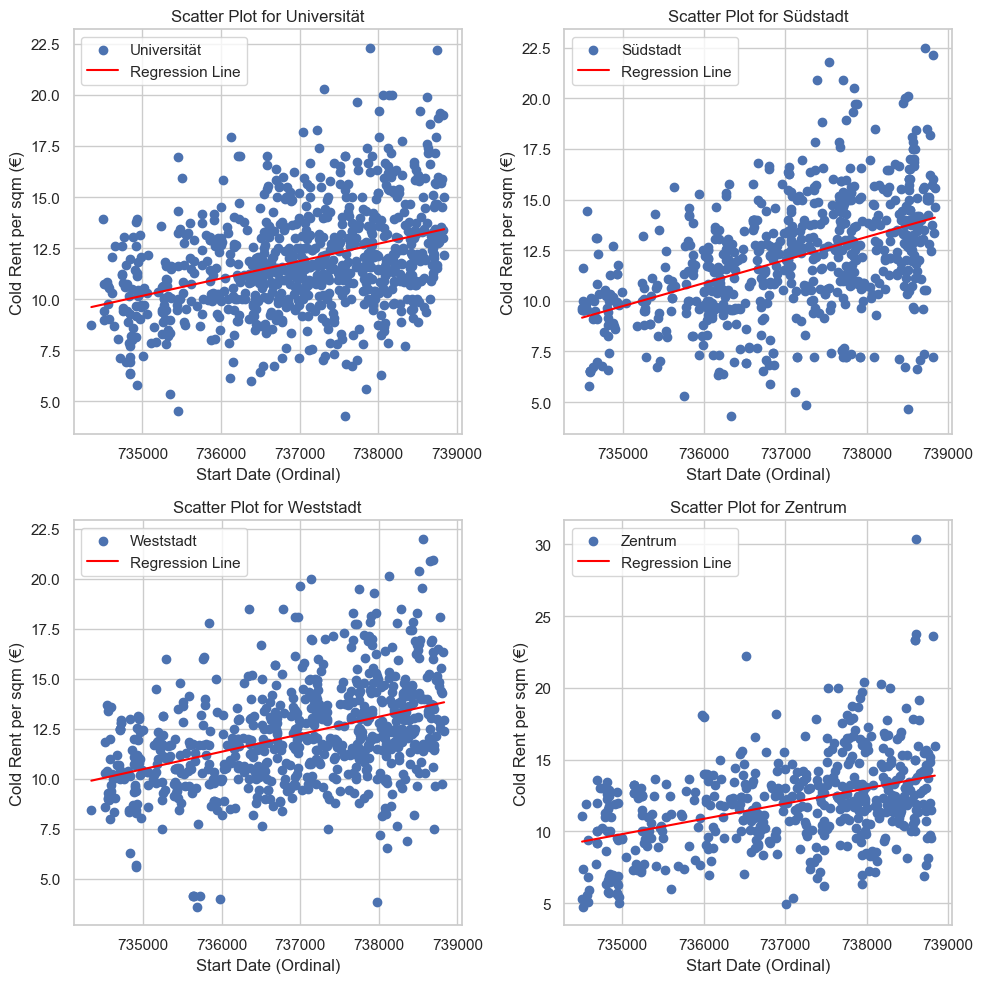

In [54]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(['Universität', 'Südstadt', 'Weststadt', 'Zentrum']):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

NameError: name 'x_ticks_labels' is not defined

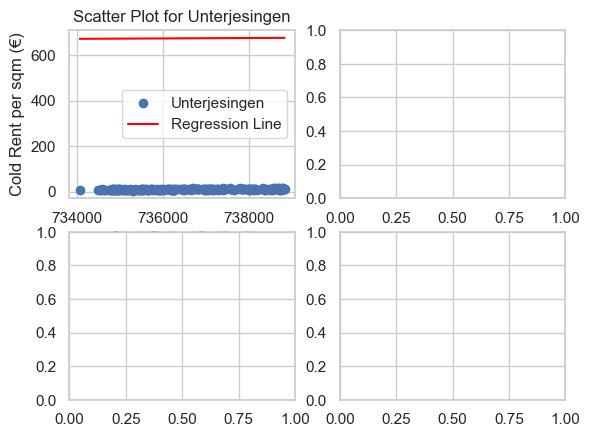

In [178]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2)  # 2 rows and 2 columns of plots

for i, region in enumerate(interesting_regions[:4]):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()

    ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

# F-Statistik
## General
$y= \beta_0 +  \boldsymbol{\beta} \cdot X $ <br>
$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_nx_n$
## Hypothesis
$H_0$: There is no relationship between the dependent and independent variable, $\beta_1=\beta_2=...=\beta_n=0$, in other words, predictor x is not able to explain the variance of the independent variable y. <br>
$H_1$: There is a relationship between the dependent and independent variable, $\beta_1 \neq 0$ or $\beta_2 \neq 0$ or ... or $\beta_n \neq 0$, in other words,  x is significant in predicting the value of y.

### Intuivly, what does the F-Statistic in our case tell us?
So, if even one of the coefficients is significant, then there is a high possibility of rejecting the null hypothesis as the coefficients are not jointly insignificant anymore. In our example, we can clearly see the slope of the line is not zero. 

## Equation
$ F=\frac{SSR_R - SSR_U / P}{SSR_U / N - P - 1}$ <br>


In [ ]:
from sklearn.feature_selection import f_regression
Y = df_w_loc_interesting_copy["kstn_miete_kalt_pqm"]
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"].values.reshape(-1, 1)
f_stat, p_val = f_regression(X, Y)
print(f"p-value: {p_val}")
print(f"f-statistic: {f_stat}")


p-value: [2.12258322e-94]
f-statistic: [468.22063241]


In [52]:
import statsmodels.api as sm

In [ ]:
import statsmodels.api as sm
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"]
X = sm.add_constant(X)
Y = df_w_loc_interesting_copy["kstn_miete_kalt_pqm"]
model = sm.OLS(Y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     kstn_miete_kalt_pqm   R-squared:                       0.174
Model:                             OLS   Adj. R-squared:                  0.173
Method:                  Least Squares   F-statistic:                     468.2
Date:                 Tue, 23 Jan 2024   Prob (F-statistic):           2.12e-94
Time:                         14:09:34   Log-Likelihood:                -5230.1
No. Observations:                 2229   AIC:                         1.046e+04
Df Residuals:                     2227   BIC:                         1.048e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
co

## Interpretation
In this, we can check the p-value (listed as Prob F-statistic) in the summary to determine whether to reject or accept the null hypothesis. Here the p-value is the probability that the null hypothesis for the full model is true (i.e., that all of the regression coefficients are zero). Since the p-value is approximately zero, we reject the null hypothesis. In other words, there is evidence that suggests that there is a linear relationship between price and the "set" of predictor variables (in our case just time).

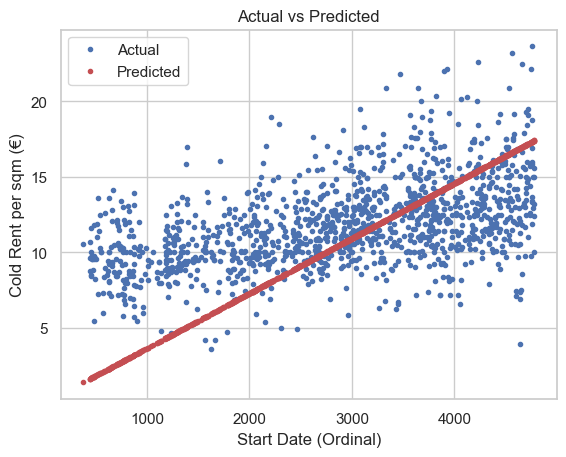

In [53]:
# split x and y in train and test
from sklearn.model_selection import train_test_split
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"].values.reshape(-1, 1)
Y = df_w_loc_interesting_copy["kstn_miete_kalt_pqm"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#Construct and fit the OLS regression model:
ols_model = sm.OLS(Y_train,X_train)
ols_results = ols_model.fit()
#Use the fitted model to make predictions on the training and testing data sets:
y_pred_train = ols_results.predict(X_train)
y_pred_test = ols_results.predict(X_test)

actual, = plt.plot(X_test, Y_test, 'b.', label='Actual')
predicted, = plt.plot(X_test, y_pred_test, 'r.', label='Predicted')
plt.legend(handles=[actual, predicted])
plt.title('Actual vs Predicted')
plt.xlabel('Start Date (Ordinal)')
plt.ylabel('Cold Rent per sqm (€)') 
plt.show()

# Watch out though, F-Test cares for multiple variables, we only have one
# We should probably use the t-test instead

# Regression T-Test
The regression t-test is applied to test if the slope, β, of the population regression line equals 0. Based on that test, we may decide whether x is a useful (linear) predictor of y.
The test-statistic follows a t-distribution with n-2 df and is defined as:

$$t=\frac{{\beta}}{s_b} = \frac{\beta}{s_e/\sqrt{\sum{(x-\hat x)^2}}}$$


In [ ]:
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"]

In [ ]:
Y.shape

(2229,)

In [ ]:
from scipy.stats import linregress

test_result = linregress(x=X, y=Y)
test_result

LinregressResult(slope=0.0009574324412807209, intercept=9.238620963991707, rvalue=0.41680038582833434, pvalue=2.1225832247087481e-94, stderr=4.424690167484012e-05, intercept_stderr=0.1276938377800706)

oadr_u2  startdate_ordinal  count
0                      Aeule             734578      1
1                      Aeule             734693      1
2                      Aeule             734873      1
3                      Aeule             734879      1
4                      Aeule             735055      1
...                      ...                ...    ...
5705  Österberg/Gartenstraße             738724      1
5706  Österberg/Gartenstraße             738740      1
5707  Österberg/Gartenstraße             738773      1
5708  Österberg/Gartenstraße             738827      1
5709  Österberg/Gartenstraße             738833      1

[5710 rows x 3 columns]

# Dates on x-axis

9.365588007307949
8.662961605885487
9.665155271020023
8.815731311307571


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_1377/1520639020.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


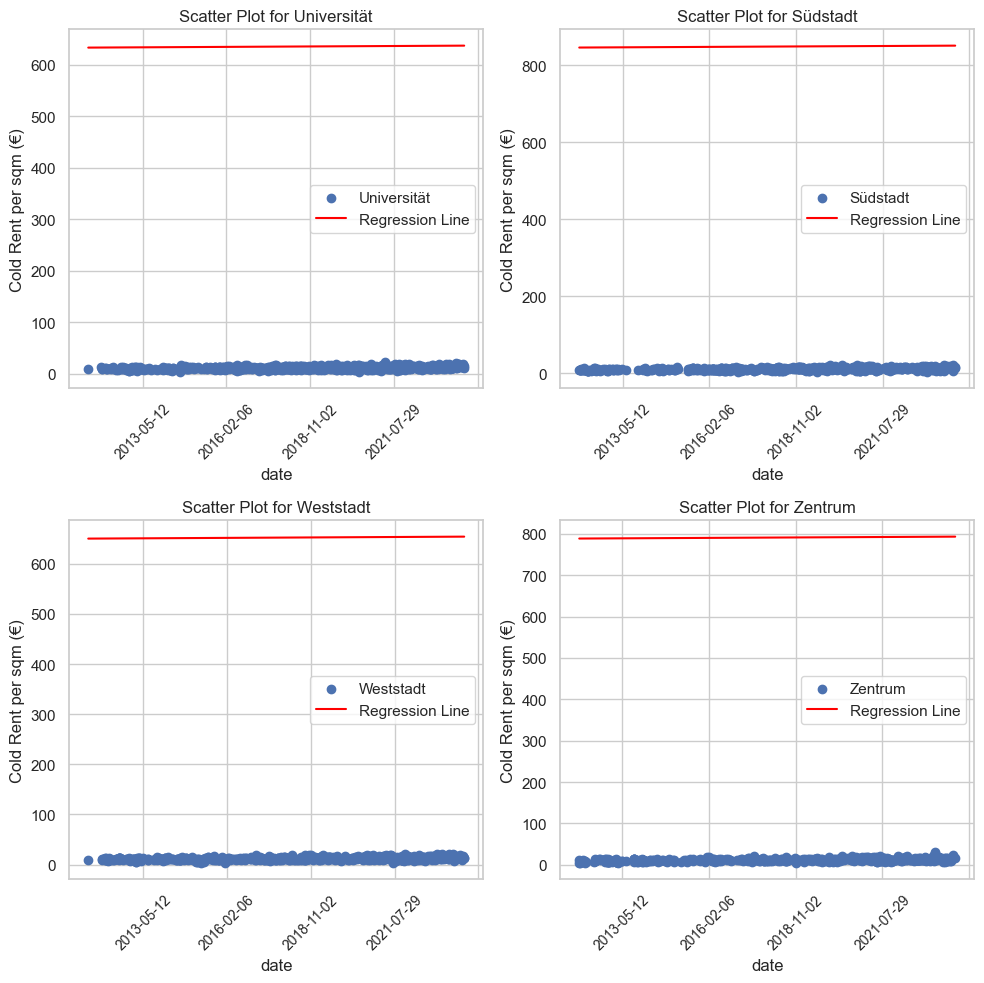

In [173]:


import matplotlib.dates as mdates
from datetime import date
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(['Universität', 'Südstadt', 'Weststadt', 'Zentrum']):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    print(intercept)
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

In [ ]:
new_labels[:len(new_labels)]

[datetime.date(2010, 8, 16),
 datetime.date(2013, 5, 12),
 datetime.date(2016, 2, 6),
 datetime.date(2018, 11, 2),
 datetime.date(2021, 7, 29),
 datetime.date(2024, 4, 24),
 datetime.date(2027, 1, 19)]

## rf

In [ ]:
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15996    40706032         2.0         3.0                       0   
16001    27375419         1.0         6.0                       0   
15998    27439257         1.0         5.0                       0   
15997    40569012         NaN         5.0                       0   
...           ...         ...         ...                     ...   
3      3594255459         1.0         3.0                       0   
2      3593975043         NaN         1.0                       0   
26     3592807854         1.0         NaN                       0   
8      3593834802         8.0        18.5                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15996                      1                        0   
16001                      1                        1   
15998                      1                        1   
15997                      0                        1   
...                      ...                      ...   
3                          1                        1   
2                          0                        0   
26                         0                        1   
8                          0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15996                           1                     1   
16001                           0                     0   
15998                           0                     1   
15997                           1                     0   
...                           ...                   ...   
3                               0                     1   
2                               0                     0   
26                              0                     0   
8                               0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15996                         0                          0   
16001                         0                          0   
15998                         0                          0   
15997                         0                          0   
...                         ...                        ...   
3                             0                          0   
2                             0                          0   
26                            0                          0   
8                             0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15996                           0                          0   
16001                           0                          1   
15998                           0                          0   
15997                           0                          0   
...                           ...                        ...   
3                               0                          0   
2                               0                          0   
26                              0                          0   
8                               1                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15996                        0                 Gas   
16001                        0          Alternativ   
15998                        0                 Gas   


In [ ]:
# drop all nan values
interesting_cols = ["anz_zimmer", "aus_heiz_system", "aus_kueche_einbau_janein", "aus_pool_janein", "baujahr", "flaeche", "kstn_miete_kalt_pqm"]
# filter based on interesting_cols
df_w_loc_interesting_rf = df_w_loc[interesting_cols]
# replace every nan with 0
df_w_loc_interesting_rf = df_w_loc_interesting_rf.fillna(0)


non_numeric_columns = df_w_loc_interesting_rf.select_dtypes(exclude=[np.number]).columns



# Apply one-hot encoding
df_encoded = pd.get_dummies(df_w_loc_interesting_rf, columns=non_numeric_columns)


In [ ]:
df_w_loc_interesting_rf

anz_zimmer aus_heiz_system  aus_kueche_einbau_janein  aus_pool_janein  \
16004         4.0         Zentral                         1                0   
15996         3.0         Zentral                         1                0   
16001         6.0         Zentral                         0                0   
15998         5.0               0                         0                0   
15997         5.0           Etage                         1                0   
...           ...             ...                       ...              ...   
3             3.0         Zentral                         0                0   
2             1.0               0                         1                0   
26            0.0               0                         0                0   
8            18.5         Zentral                         0                0   
1             2.0               0                         1                0   

       baujahr  flaeche  kstn_miete_kalt_pqm  
16004      0.0    87.00                 7.24  
15996   2001.0    72.65                 0.00  
16001      0.0   147.00                 0.00  
15998   2011.0   168.70                 0.00  
15997   1515.0   147.00                 9.69  
...        ...      ...                  ...  
3       2011.0   109.58                15.97  
2       1984.0    40.00                10.00  
26         0.0   219.87                 0.00  
8       1876.0   576.50                 0.00  
1       1980.0    50.00                15.00  

[11927 rows x 7 columns]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
df = df_encoded
# Assuming df is your DataFrame and 'kstn_miete_kalt_pqm' is the target variable (price)
X = df.drop('kstn_miete_kalt_pqm', axis=1)  # Features
y = df['kstn_miete_kalt_pqm']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature flaeche (0.41336331232491585)
2. feature baujahr (0.2991940240629079)
3. feature anz_zimmer (0.13657552680227042)
4. feature aus_kueche_einbau_janein (0.09187386359728096)
5. feature aus_heiz_system_0 (0.022350888575332087)
6. feature aus_heiz_system_Zentral (0.02187708972545537)
7. feature aus_heiz_system_Etage (0.009050040322252767)
8. feature aus_heiz_system_Zimmer (0.005346120043272108)
9. feature aus_pool_janein (0.00036913454631252627)


In [ ]:
import shap

# Initialize the SHAP values calculator
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


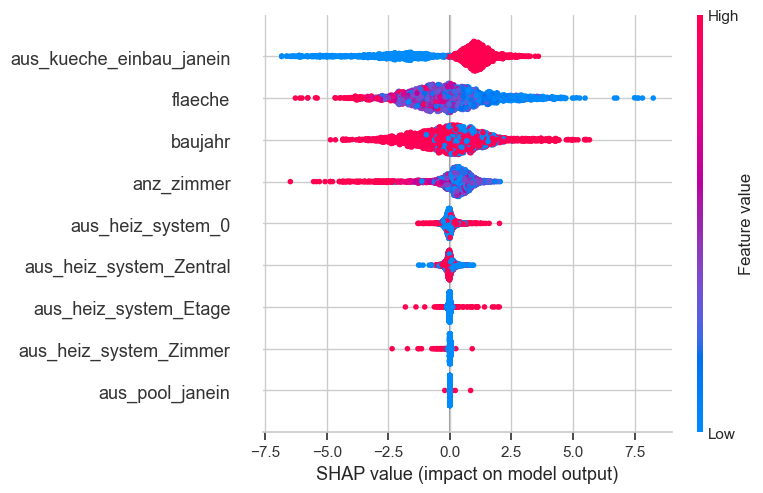

In [ ]:
# Create a summary plot for all the test set predictions
shap.summary_plot(shap_values, X_test)


In [ ]:
df_w_loc[df_w_loc["oadr_u2"].notna()]["baujahr"].isna().sum()

2106

In [ ]:
df_w_loc["oadr_u2"].isna().sum()

2796

In [ ]:
df_w_loc["baujahr"].isna().sum()

2872

## Maybe dont use toordinal, it messes up the x-axis

## What should we take for x ? 

# IGNORE

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf_2 = gpd.read_file("../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp")

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf_2.plot(ax=ax, cmap='viridis', edgecolor='black', legend=True)

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


DriverError: ../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp: No such file or directory

In [ ]:
tuebingen_gdf_2.columns

In [ ]:
# init_path = "../data/tuebingen-regbez-latest-free/"
# shp_file_paths = ['gis_osm_buildings_a_free_1.shp', 'gis_osm_landuse_a_free_1.shp', 'gis_osm_natural_a_free_1.shp' ,'gis_osm_natural_free_1.shp', 'gis_osm_places_a_free_1.shp', 'gis_osm_places_free_1.shp','gis_osm_pofw_a_free_1.shp', '']

# # Create a list to store GeoDataFrames
# gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# # Create a larger plot with a specified size
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot each GeoDataFrame with a different color
# for i, gdf in enumerate(gdfs):
#     gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# # Add labels and legend
# plt.title('Combined Plot of Multiple Shapefiles')
# plt.legend()

# # Show the plot
# plt.show()


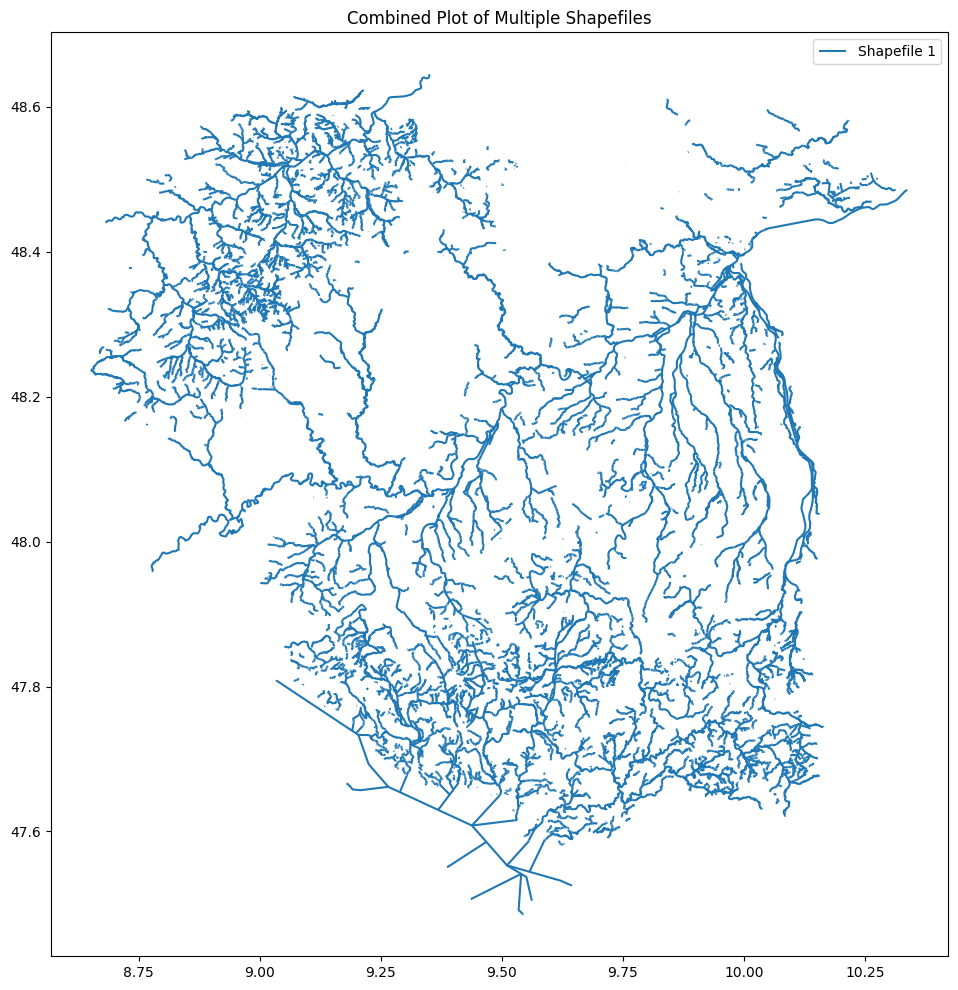

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_waterways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5419/38635465.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


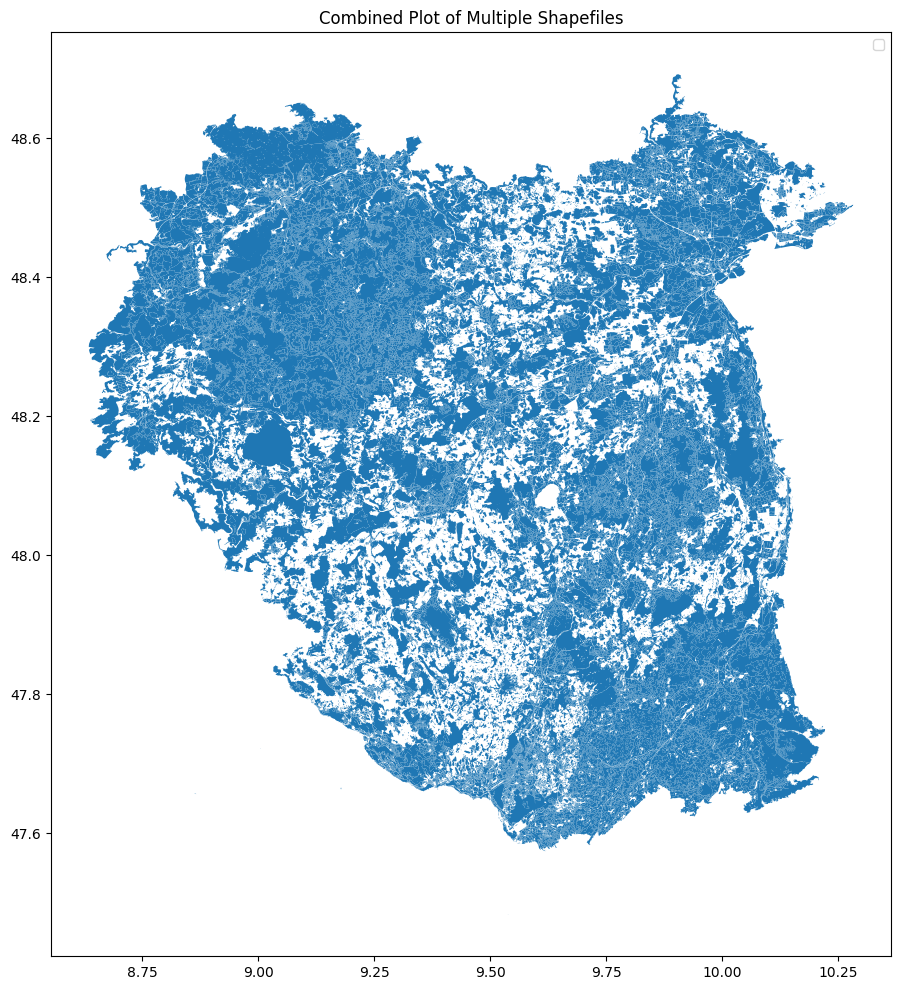

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_landuse_a_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


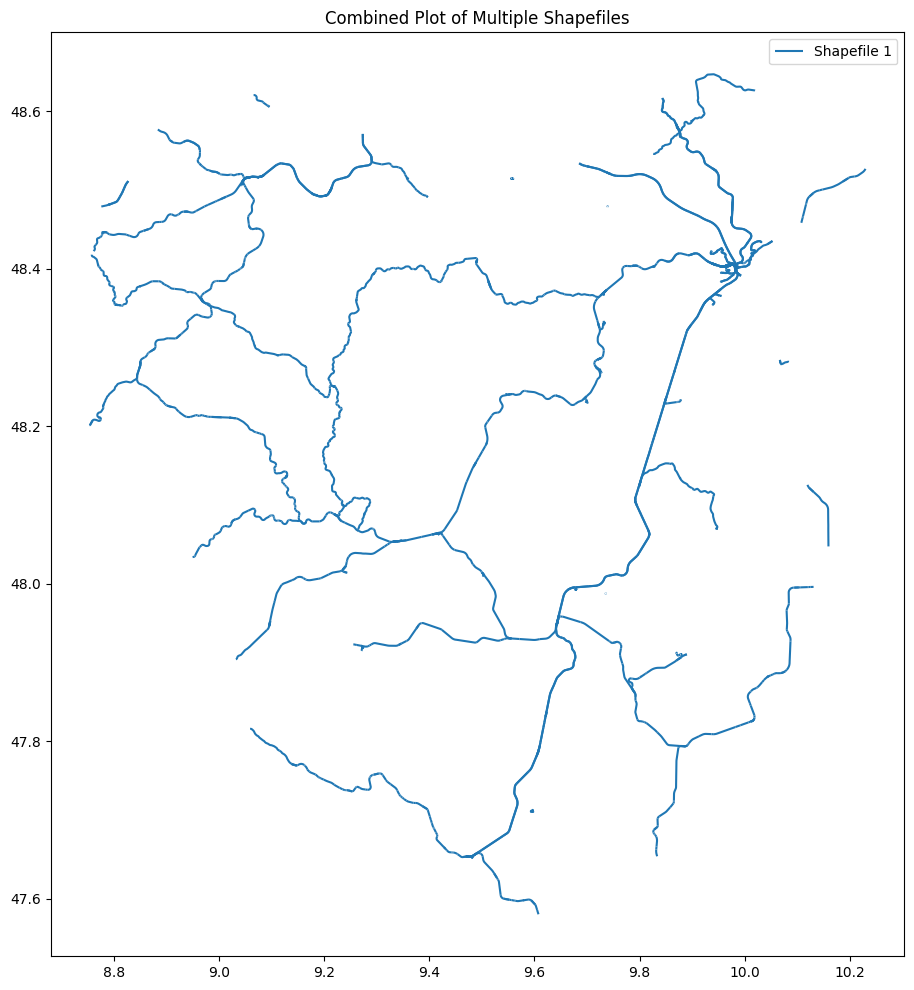

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_railways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()
